# Stationary SCM and DAG (STAT.) from figure 1 in paper

In [1]:
%load_ext autoreload
%autoreload 2

from dcbo.examples.example_setups import setup_stat_scm
from dcbo.utils.sequential_sampling import sequentially_sample_model
from dcbo.utils.sem_utils.toy_sems import StationaryDependentSEM as StatSEM
from dcbo.utils.plotting import plot_outcome
from dcbo.utils.sem_utils.sem_estimate import build_sem_hat

from numpy.random import seed

# Models
from dcbo.methods.bo import BO
from dcbo.methods.cbo import CBO
from dcbo.methods.abo import ABO
from dcbo.methods.dcbo import DCBO

seed(seed=0)

## Sample SEM to get observational samples

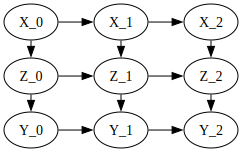

In [2]:
T = 3 # In this example, as in the paper, we consider three time-slices
init_sem, sem, dag_view, G, exploration_sets, intervention_domain, true_objective_values, optimal_interventions, all_causal_effects  = setup_stat_scm(T=T)
# This is just a snapshot of the DAG at hand
dag_view

The above DAG is the graphical structure we will be working with and is faithful to the one used in figure one in the paper. `dag` is a networkx object i.e.

In [3]:
type(G)

networkx.classes.multidigraph.MultiDiGraph

and is the one we will use for exploring the optimization methods further down. `dag_view` is simply a convenient way to visualise the structure at hand and is just a string that we visulise using `pygraphviz`:

In [4]:
print(dag_view)

digraph { rankdir=LR; X_0 -> Z_0; Z_0 -> Y_0; X_1 -> Z_1; Z_1 -> Y_1; X_2 -> Z_2; Z_2 -> Y_2;  X_0 -> X_1; Z_0 -> Z_1; Y_0 -> Y_1; X_1 -> X_2; Z_1 -> Z_2; Y_1 -> Y_2;  { rank=same; X_0 Z_0 Y_0 } { rank=same; X_1 Z_1 Y_1 } { rank=same; X_2 Z_2 Y_2 }  }



Notice that we make use of two types of structural equations models: `init_sem` and `sem`. The latter concerns interactions with the first time-slice in the DBN, which has no incoming edges from the previous time-slices, and is only active at $t=0$. For all other time-slices i.e. when $t>0$ the `sem` model is used.

In [5]:
# Number of independent samples (samples here are the time-series on the horizontal) per time-index
D_O = sequentially_sample_model(init_sem,
                                sem,
                                total_timesteps=T,
                                sample_count=20, # How many samples we take per node in each time-slice
                                epsilon=None) # If we employ a noise model or not

In [6]:
# Simulate some interventional data

from dcbo.utils.utilities import powerset, get_monte_carlo_expectation
from dcbo.utils.sequential_intervention_functions import make_sequential_intervention_dict
from numpy import zeros

D_I = {k: None for k in powerset(["X", "Z"])}
"""
do(Z_0)
"""
interv = make_sequential_intervention_dict(G,T)
# Univariate intervention at time 0
interv["Z"][0] = 1.0
static_noise_model = {k: zeros(T) for k in ["X", "Z", "Y"]}
# Sample this model with one intervention, and no noise
intervention_samples = sequentially_sample_model(
    init_sem,
    sem,
    total_timesteps=T,
    interventions=interv,
    sample_count=1,
    epsilon=static_noise_model
)

# Note: we obvs don't need to take MC samples if noise-model is zero
D_I[("Z",)] = get_monte_carlo_expectation(intervention_samples)


The above observation samples contained in `D_obs` are sequential in the sense that the sample function generates each column per variable, conditional on the column samples at $t-1$.

## Other setup parameters 

In [7]:
# Contains the exploration sets we will be investigating
print("Exploration sets:", exploration_sets)
# The intervention domains for the manipulative variables
print("Intervention domains:", intervention_domain) 
# The true outcome values of Y given an optimal intervention on the three time-slices
print("True optimal outcome values:", [r"y^*_{} = {}".format(t,val.round(3)) for t,val in enumerate(true_objective_values)])
# Number of trials
N = 10

Exploration sets: [('X',), ('Z',), ('X', 'Z')]
Intervention domains: {'X': [-4, 1], 'Z': [-3, 3]}
True optimal outcome values: ['y^*_0 = -2.152', 'y^*_1 = -4.304', 'y^*_2 = -6.455']


## Explore optimization methods

In all these examples we do not employ any interventional data, just observational.

### Vanilla Bayesian Optimization 

In [8]:
# Setup the input parameters to be used with the Bayesian optimization
BO_input_params = {
    "G":G,
    "sem": StatSEM,
    "base_target_variable": "Y",
    "observation_samples": D_O, # Observational samples
    "intervention_domain": intervention_domain,
    "intervention_samples":None,   
    "number_of_trials": N,
    "optimal_assigned_blankets": None,
    "sample_anchor_points": True,
    "seed_anchor_points": 1,
    "change_points": None
}
# Run Bayesian optimization
bo = BO(**BO_input_params)
bo.run()

Time index:  33%|███▎      | 1/3 [00:00<00:00,  8.22it/s]reconstraining parameters GP_regression.rbf.variance


improvements shape : (10, 2)
improvements shape : (10, 1)
improvements shape : (10, 1)
improvements shape : (10, 1)
improvements shape : (10, 1)
improvements shape : (10, 1)
improvements shape : (10, 1)
improvements shape : (10, 1)
improvements shape : (10, 1)
improvements shape : (10, 1)
improvements shape : (10, 2)
improvements shape : (10, 1)
improvements shape : (10, 1)
improvements shape : (10, 1)


Time index:  67%|██████▋   | 2/3 [00:00<00:00,  6.64it/s]reconstraining parameters GP_regression.rbf.variance


improvements shape : (10, 1)
improvements shape : (10, 1)
improvements shape : (10, 1)
improvements shape : (10, 1)
improvements shape : (10, 1)
improvements shape : (10, 1)
improvements shape : (10, 2)
improvements shape : (10, 1)
improvements shape : (10, 1)
improvements shape : (10, 1)
improvements shape : (10, 1)
improvements shape : (10, 1)
improvements shape : (10, 1)
improvements shape : (10, 1)


Time index: 100%|██████████| 3/3 [00:00<00:00,  6.94it/s]

improvements shape : (10, 1)
improvements shape : (10, 1)


Time index: 100%|██████████| 3/3 [00:00<00:00,  6.98it/s]


In [9]:
bo.assigned_blanket

{'X': [-1.5005874958722, -3.9271251875729014, -1.0247396789687988],
 'Y': [-2.111148824950811, -4.26018454126298, -6.103437908573766],
 'Z': [-2.8506046346979117, -2.9864445988889186, 2.941345628240498]}

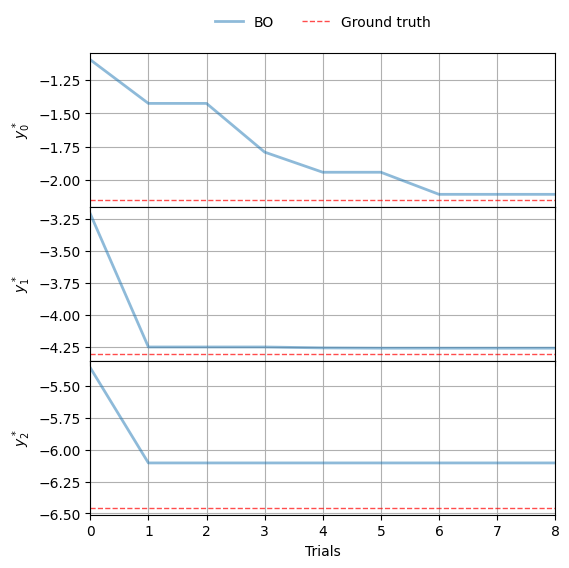

In [10]:
plot_outcome(T,N,outcomes=[bo.optimal_outcome_values_during_trials],labels=['BO'],true_objective_values=true_objective_values)

### Adaptive Bayesian Optimization
The setup for ABO is the same as for BO.

In [11]:
abo = ABO(**BO_input_params)
abo.run()

Time index:   0%|          | 0/3 [00:00<?, ?it/s]reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance


improvements shape : (10, 3)
improvements shape : (10, 1)
improvements shape : (10, 1)
improvements shape : (10, 1)
improvements shape : (10, 1)
improvements shape : (10, 1)
improvements shape : (10, 1)
improvements shape : (10, 1)
improvements shape : (10, 1)
improvements shape : (10, 1)
improvements shape : (10, 3)
improvements shape : (10, 1)
improvements shape : (10, 1)
improvements shape : (10, 1)
improvements shape : (10, 1)
improvements shape : (10, 1)
improvements shape : (10, 1)
improvements shape : (10, 1)
improvements shape : (10, 1)
improvements shape : (10, 1)


Time index: 100%|██████████| 3/3 [00:00<00:00,  7.07it/s]

improvements shape : (10, 3)
improvements shape : (10, 1)
improvements shape : (10, 1)
improvements shape : (10, 1)
improvements shape : (10, 1)
improvements shape : (10, 1)
improvements shape : (10, 1)
improvements shape : (10, 1)
improvements shape : (10, 1)
improvements shape : (10, 1)


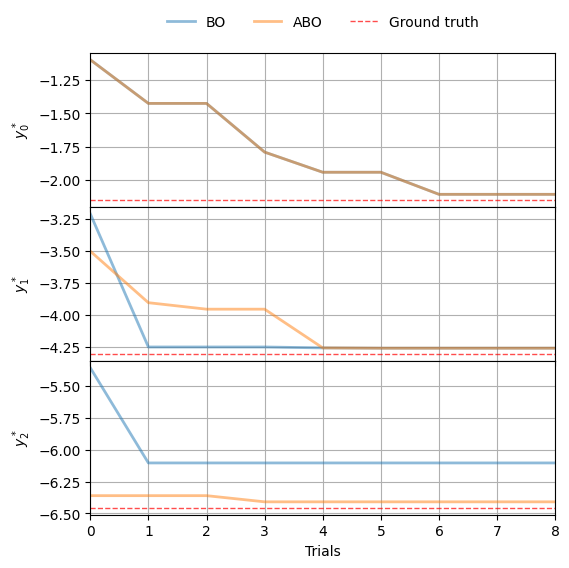

In [12]:
plot_outcome(T,N,outcomes=[bo.optimal_outcome_values_during_trials,abo.optimal_outcome_values_during_trials],labels=['BO', 'ABO'],true_objective_values=true_objective_values)

### Causal Bayesian Optimization
CBO has one extra parameter (though there are many others which we are not demonstrating in this demo) which is the SEM estimator method `build_sem_hat`. It estimates a SEM model from the observational data.

In [13]:

CBO_input_params = {
    "G": G,
    "sem": StatSEM,
    "base_target_variable": "Y",
    "make_sem_estimator": build_sem_hat,
    "exploration_sets":exploration_sets,
    "observation_samples": D_O,
    "intervention_samples":D_I, # Interventional data as well
    "intervention_domain": intervention_domain,
    "intervention_samples":None,
    "number_of_trials": N,
    "sample_anchor_points": True,
    "seed_anchor_points": 1,
    "debug_mode":False,
    "ground_truth":all_causal_effects
}

In [14]:
cbo = CBO(**CBO_input_params)
cbo.run()

Time index:   0%|          | 0/3 [00:00<?, ?it/s]reconstraining parameters GP_regression.rbf.variance


improvements shape : (100, 1)
improvements shape : (100, 1)
improvements shape : (10, 1)
improvements shape : (100, 1)


reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance


improvements shape : (100, 1)
improvements shape : (10, 1)
improvements shape : (100, 1)
improvements shape : (100, 1)
improvements shape : (10, 1)


reconstraining parameters GP_regression.rbf.variance


improvements shape : (100, 1)
improvements shape : (100, 1)
improvements shape : (10, 1)
improvements shape : (100, 1)


reconstraining parameters GP_regression.rbf.variance


improvements shape : (100, 1)
improvements shape : (10, 1)
improvements shape : (100, 1)


reconstraining parameters GP_regression.rbf.variance


improvements shape : (100, 1)
improvements shape : (10, 1)
improvements shape : (100, 1)


reconstraining parameters GP_regression.rbf.variance


improvements shape : (100, 1)
improvements shape : (10, 1)
improvements shape : (100, 1)


reconstraining parameters GP_regression.rbf.variance


improvements shape : (100, 1)
improvements shape : (10, 1)
improvements shape : (100, 1)


reconstraining parameters GP_regression.rbf.variance
Time index:  33%|███▎      | 1/3 [00:02<00:04,  2.21s/it]

improvements shape : (100, 1)
improvements shape : (10, 1)
improvements shape : (100, 1)


reconstraining parameters GP_regression.rbf.variance


improvements shape : (100, 1)
improvements shape : (10, 1)
improvements shape : (100, 1)


reconstraining parameters GP_regression.rbf.variance


improvements shape : (100, 1)
improvements shape : (10, 1)
improvements shape : (100, 1)


reconstraining parameters GP_regression.rbf.variance


improvements shape : (100, 1)
improvements shape : (10, 1)
improvements shape : (100, 1)


reconstraining parameters GP_regression.rbf.variance


improvements shape : (100, 1)
improvements shape : (10, 1)


reconstraining parameters GP_regression.rbf.variance


improvements shape : (100, 1)
improvements shape : (100, 1)
improvements shape : (10, 1)


reconstraining parameters GP_regression.rbf.variance


improvements shape : (100, 1)
improvements shape : (100, 1)
improvements shape : (10, 1)


reconstraining parameters GP_regression.rbf.variance


improvements shape : (100, 1)
improvements shape : (100, 1)
improvements shape : (10, 1)


reconstraining parameters GP_regression.rbf.variance


improvements shape : (100, 1)
improvements shape : (100, 1)
improvements shape : (10, 1)


reconstraining parameters GP_regression.rbf.variance
Time index:  67%|██████▋   | 2/3 [00:05<00:02,  2.79s/it]

improvements shape : (100, 1)
improvements shape : (100, 1)
improvements shape : (10, 1)


reconstraining parameters GP_regression.rbf.variance


improvements shape : (100, 1)
improvements shape : (100, 1)
improvements shape : (10, 1)


reconstraining parameters GP_regression.rbf.variance


improvements shape : (100, 1)
improvements shape : (100, 1)
improvements shape : (10, 1)


reconstraining parameters GP_regression.rbf.variance


improvements shape : (100, 1)
improvements shape : (100, 1)
improvements shape : (10, 1)
improvements shape : (100, 1)


reconstraining parameters GP_regression.rbf.variance


improvements shape : (100, 1)
improvements shape : (10, 1)


reconstraining parameters GP_regression.rbf.variance


improvements shape : (100, 1)
improvements shape : (100, 1)
improvements shape : (10, 1)


reconstraining parameters GP_regression.rbf.variance


improvements shape : (100, 1)
improvements shape : (100, 1)
improvements shape : (10, 1)


reconstraining parameters GP_regression.rbf.variance


improvements shape : (100, 1)
improvements shape : (100, 1)
improvements shape : (10, 1)


reconstraining parameters GP_regression.rbf.variance


improvements shape : (100, 1)
improvements shape : (100, 1)
improvements shape : (10, 1)


reconstraining parameters GP_regression.rbf.variance


improvements shape : (100, 1)
improvements shape : (100, 1)
improvements shape : (10, 1)


Time index: 100%|██████████| 3/3 [00:09<00:00,  3.12s/it]


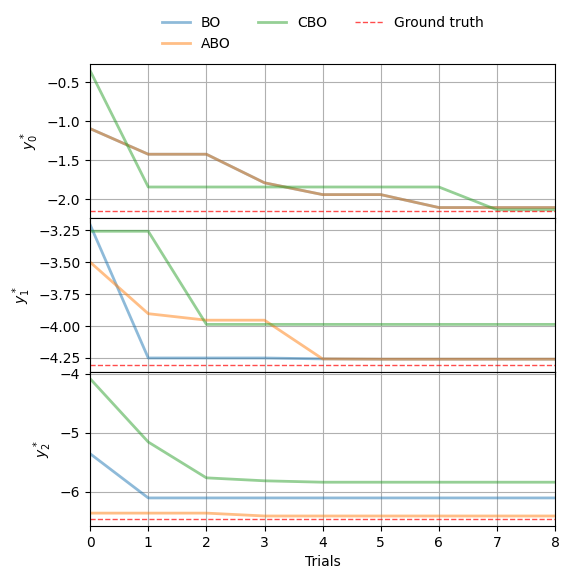

In [15]:
plot_outcome(T,N,outcomes=[bo.optimal_outcome_values_during_trials, abo.optimal_outcome_values_during_trials, cbo.optimal_outcome_values_during_trials],labels=['BO', 'ABO', 'CBO'],true_objective_values=true_objective_values)

### Dynamic Causal Bayesian Optimization

DCBO has the same input parameters as CBO. But they work very differently under the hood. DCBO takes 'horizontal' information into account i.e. is able to transfer information between time-slices. CBO has no notion of time.

In [16]:
dcbo = DCBO(**CBO_input_params)
dcbo.run()

 /Users/lucaswychan/DCBO/dcbo_venv/lib/python3.10/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in divide
 /Users/lucaswychan/DCBO/dcbo_venv/lib/python3.10/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/lucaswychan/DCBO/dcbo_venv/lib/python3.10/site-packages/GPy/kern/src/rbf.py:178: RuntimeWarning:invalid value encountered in multiply
Time index:   0%|          | 0/3 [00:00<?, ?it/s]reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance


improvements shape : (100, 1)
improvements shape : (100, 1)
improvements shape : (10, 1)
improvements shape : (100, 1)
improvements shape : (100, 1)
improvements shape : (10, 1)
improvements shape : (100, 1)
improvements shape : (100, 1)
improvements shape : (10, 1)
improvements shape : (100, 1)
improvements shape : (100, 1)
improvements shape : (10, 1)


reconstraining parameters GP_regression.rbf.variance


improvements shape : (100, 1)
improvements shape : (100, 1)
improvements shape : (10, 1)
improvements shape : (100, 1)
improvements shape : (100, 1)
improvements shape : (10, 1)
improvements shape : (100, 1)
improvements shape : (100, 1)
improvements shape : (10, 1)
improvements shape : (100, 1)
improvements shape : (100, 1)
improvements shape : (10, 1)


Time index:  33%|███▎      | 1/3 [00:01<00:03,  1.72s/it]

improvements shape : (100, 1)
improvements shape : (100, 1)
improvements shape : (10, 1)


reconstraining parameters GP_regression.rbf.variance


improvements shape : (100, 1)
improvements shape : (100, 1)
improvements shape : (10, 1)


reconstraining parameters GP_regression.rbf.variance


improvements shape : (100, 1)
improvements shape : (100, 1)
improvements shape : (10, 1)


reconstraining parameters GP_regression.rbf.variance


improvements shape : (100, 1)
improvements shape : (100, 1)
improvements shape : (10, 1)
improvements shape : (100, 1)
improvements shape : (100, 1)
improvements shape : (10, 1)
improvements shape : (100, 1)
improvements shape : (100, 1)
improvements shape : (10, 1)
improvements shape : (100, 1)
improvements shape : (100, 1)
improvements shape : (10, 1)
improvements shape : (100, 1)
improvements shape : (100, 1)
improvements shape : (10, 1)
improvements shape : (100, 1)


Time index:  67%|██████▋   | 2/3 [00:04<00:02,  2.52s/it]

improvements shape : (100, 1)
improvements shape : (10, 1)
improvements shape : (100, 1)
improvements shape : (100, 1)
improvements shape : (10, 1)


reconstraining parameters GP_regression.rbf.variance


improvements shape : (100, 1)
improvements shape : (100, 1)
improvements shape : (10, 1)


reconstraining parameters GP_regression.rbf.variance


improvements shape : (100, 1)
improvements shape : (100, 1)
improvements shape : (10, 1)
improvements shape : (100, 1)
improvements shape : (100, 1)
improvements shape : (10, 1)
improvements shape : (100, 1)


reconstraining parameters GP_regression.rbf.variance


improvements shape : (100, 1)
improvements shape : (10, 1)
improvements shape : (100, 1)
improvements shape : (100, 1)
improvements shape : (10, 1)
improvements shape : (100, 1)
improvements shape : (100, 1)
improvements shape : (10, 1)
improvements shape : (100, 1)
improvements shape : (100, 1)
improvements shape : (10, 1)
improvements shape : (100, 1)
improvements shape : (100, 1)
improvements shape : (10, 1)
improvements shape : (100, 1)
improvements shape : (100, 1)
improvements shape : (10, 1)


Time index: 100%|██████████| 3/3 [00:08<00:00,  2.75s/it]


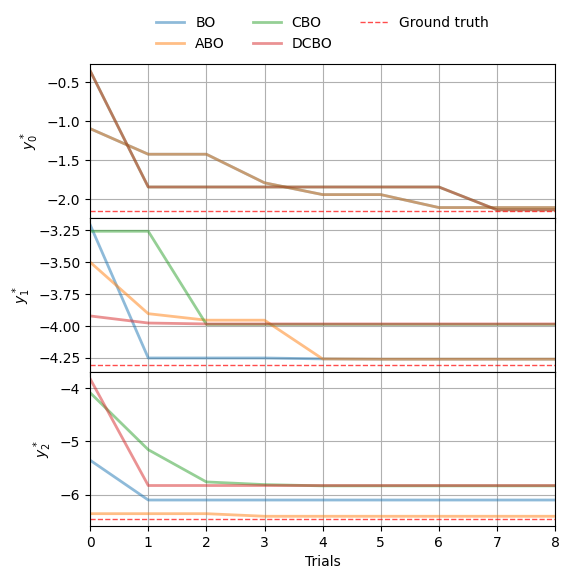

In [17]:
plot_outcome(T,N,outcomes=[bo.optimal_outcome_values_during_trials, abo.optimal_outcome_values_during_trials, cbo.optimal_outcome_values_during_trials, dcbo.optimal_outcome_values_during_trials],labels=['BO', 'ABO', 'CBO', 'DCBO'],true_objective_values=true_objective_values)